# 1. Klasyfikacja danych MIST przy użyciu K-neighbours

In [1]:
# Importuje standardowe biblioteki
import numpy as np
import os

# Aby wyniki uzyskiwane w tym notatniku były odtwarzalne
np.random.seed(42)

# Do rysowania ładnych wykresów
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Przygotowanie danych

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
#dzielenie danych na zbiór treningowy i testowy
X, y = mnist["data"], mnist["target"]
X_train, X_test, y_train, y_test = X[60000:], X[:60000], y[60000:], y[:60000]

# Klasyfikator

In [4]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

KNeighborsClassifier()

In [5]:
example = X[1] #0
knn_clf.predict([example])

array(['0'], dtype=object)

In [6]:
from sklearn.model_selection import cross_val_predict, cross_val_score
cross_val_score(knn_clf,X_train, y_train, cv=3, scoring="accuracy")

array([0.91211758, 0.93789379, 0.9579958 ])

In [7]:
from sklearn.model_selection import GridSearchCV

#bez sensownego procesora lepiej nie zalaczac
knn_for_test = KNeighborsClassifier()
clf = GridSearchCV(knn_for_test, {
    'weights' : ['distance', 'uniform'],
    'n_neighbors' : [2,3,4],
    'p' : [2.2,2.3,2.4]
}, cv = 2, verbose = 3)

clf.fit(X_train, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] n_neighbors=3, p=2.3, weights=distance ..........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_neighbors=3, p=2.3, weights=distance, score=0.887, total= 5.3min
[CV] n_neighbors=3, p=2.3, weights=distance ..........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.3min remaining:    0.0s


[CV]  n_neighbors=3, p=2.3, weights=distance, score=0.944, total= 5.3min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 10.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 10.6min finished


GridSearchCV(cv=2, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3], 'p': [2.3],
                         'weights': ['distance']},
             verbose=3)

In [28]:
clf.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [29]:
clf.best_score_

0.9492

# 2. To samo, ale po dogenerowaniu danych

In [5]:
from scipy.ndimage.interpolation import shift
from sklearn.neighbors import KNeighborsClassifier

In [6]:
def shift_image(image,dx,dy):
    image = image.reshape((28,28))
    shifted_image = shift(image, [dy,dx], cval = 0, mode="constant")
    return shifted_image.reshape(-1)

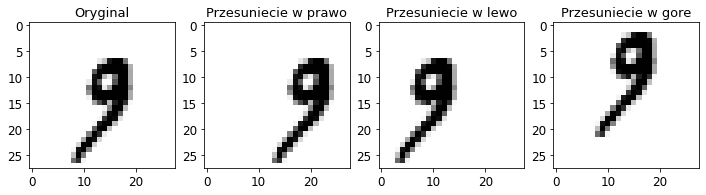

In [7]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

image = X_train[1000]
shifted_image_right = shift_image(image,5, 0)
shifted_image_up = shift_image(image, 0, -5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,6))
plt.subplot(141)
plt.title("Oryginal", fontsize=13)
plt.imshow(image.reshape(28,28), interpolation = "nearest", cmap = "Greys")

plt.subplot(142)
plt.title("Przesuniecie w prawo", fontsize=13)
plt.imshow(shifted_image_right.reshape(28,28),interpolation = "nearest", cmap="Greys")

plt.subplot(143)
plt.title("Przesuniecie w lewo", fontsize=13)
plt.imshow(shifted_image_left.reshape(28,28),interpolation = "nearest", cmap="Greys")


plt.subplot(144)
plt.title("Przesuniecie w gore", fontsize=13)
plt.imshow(shifted_image_up.reshape(28,28), interpolation = "nearest", cmap="Greys")
plt.show()

In [8]:
X_train_enriched = [image for image in X_train]
y_train_enriched = [label for label in y_train]

for dx, dy in ((3,0), (-3,0), (0,1), (0,-1)):
    for image, label in zip(X_train, y_train):
        X_train_enriched.append(shift_image(image,dx,dy))
        y_train_enriched.append(label)

X_train_enriched = np.array(X_train_enriched)
y_train_enriched = np.array(y_train_enriched)

In [9]:
shuffle_idx = np.random.permutation(len(X_train_enriched))
X_train_enriched = X_train_enriched[shuffle_idx]
y_train_enriched = y_train_enriched[shuffle_idx]

In [10]:
knn_clf = KNeighborsClassifier(weights = 'distance', n_neighbors = 4 )
#knn_clf = KNeighborsClassifier(**grid_search.best_params_) 

In [11]:
knn_clf.fit(X_train_enriched, y_train_enriched)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [ ]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

# Klasyfikacja przy użyciu zespołu klasyfikatorów

In [1]:
# Importuje standardowe biblioteki
import numpy as np
import os

# Aby wyniki uzyskiwane w tym notatniku były odtwarzalne
np.random.seed(42)

# Do rysowania ładnych wykresów
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [10]:
from sklearn.model_selection import train_test_split

#X_train_val, X_test, y_train_val, y_test = train_test_split(
#    mnist.data, mnist.target, test_size=10000, random_state=42)
#X_train, X_val, y_train, y_val = train_test_split(
#    X_train_val, y_train_val, test_size=10000, random_state=42)

idx = np.random.permutation(60000)[:10000]
X = mnist['data'][idx]
y = mnist['target'][idx]

idx = np.random.permutation(60000)[:2500]
X_test = mnist['data'][idx]
y_test = mnist['target'][idx]

Jako że niektóre algorytmy (w tym SVM) mogą działać za długo, należy dokonać redukcji wymiarowości. tSNE grupuje podobne elementy, więc w obliczu klasyfikacji liczb sprawdzi się dobrze. Na dużych zbiorach wykonuje się natomiast bardzo wolno - przyspieszę ten proces poprzedzając go analizą PCA z zachowaniem 95% wariancji. Znacznie przyspieszy tSNE niewielkim kosztem dokładności. 2 wymiary posłużą do prezentacji wykresu.

In [17]:
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

pca_tsne = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=1)),
    ("tsne", TSNE(n_components=2, random_state=1))
])

X_reduced = pca_tsne.fit_transform(X)
X_reduced_test = pca_tsne.fit_transform(X_test)

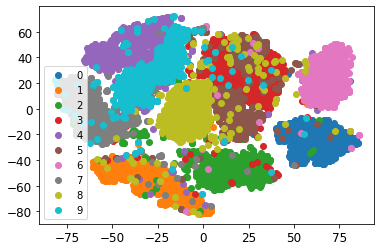

In [28]:
fig, ax = plt.subplots()
scatter_x = X_reduced[:,0]
scatter_y = X_reduced[:,1]
for g in np.unique(y):
    i = np.where(y == g)
    ax.scatter(scatter_x[i], scatter_y[i], label=g)
ax.legend()
plt.show()

Grupowanie przebiegło pomyślnie, ale jak się okazuje modele działają gorzej niż losowo. Do lepszych wyników potrzeba przede wszystkim więcej prób uczących (a więc i więcej czasu) i więcej wymiarów. 2 wymiary nadają się do prezentacji danych, ale na pewno nie do tworzenia dobrych modeli.

In [14]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier

ext_clf = ExtraTreesClassifier(random_state=1)
svm_clf = SVC(gamma="scale", probability=True, random_state=1)
rf_clf = RandomForestClassifier(random_state=1)

voter = VotingClassifier(
    estimators = [('ext', ext_clf), ('svm', svm_clf), ('rf', rf_clf)],
    voting = 'soft', verbose = True)

In [15]:
from sklearn.metrics import accuracy_score

for clf in (ext_clf, svm_clf, rf_clf, voter):
    clf.fit(X_reduced, y)
    
    y_pred = clf.predict(X_reduced_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))
    

ExtraTreesClassifier 0.3048
SVC 0.3208
RandomForestClassifier 0.2976
[Voting] ...................... (1 of 3) Processing ext, total=   0.5s
[Voting] ...................... (2 of 3) Processing svm, total=   1.8s
[Voting] ....................... (3 of 3) Processing rf, total=   1.0s
VotingClassifier 0.3108


Te same modele dają wynik powyżej 98% jeżeli wytrenuje się je na pełnym zbiorze uczącym i zastosuje głosowanie miękkie. W przypadku SVM warto zastosować parametry gamma = 0.005 i C=5, uprzednio skalując dane. Niestety, ale takie zmiany wydłużają czas trenowania modelu jeszcze bardziej.

# Klasyfikacja z użyciem TensorFlow

In [21]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
%load_ext tensorboard
np.random.seed(42)

# Do rysowania ładnych wykresów
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

NameError: name 'keras' is not defined

In [23]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

Zastosuję harmonogramowanie wykładnicze:

In [24]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

In [25]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [26]:
model = keras.models.Sequential([
  keras.layers.Flatten(input_shape = [28,28]),
  keras.layers.Dense(300, activation="relu"),
  keras.layers.Dense(100, activation="relu"),
  keras.layers.Dense(10, activation="softmax")
])

In [27]:
model.compile(loss="sparse_categorical_crossentropy",
             optimizer=keras.optimizers.SGD(lr=1e-3),
             metrics=["accuracy"])
exp_lr = ExponentialLearningRate(factor=1.005)

In [28]:
keras.backend.clear_session()
X_train.dtype

dtype('float64')

In [29]:
history = model.fit(X_train, y_train, epochs=1, validation_data = (X_valid, y_valid), callbacks=[exp_lr])

1719/1719 [==============================] - 4s 2ms/step - loss: 79462722046.2221 - accuracy: 0.4872 - val_loss: 2.3911 - val_accuracy: 0.1126


Text(0, 0.5, 'Funkcja straty')

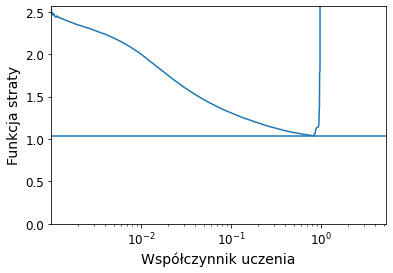

In [30]:
plt.plot(exp_lr.rates, exp_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(exp_lr.losses), min(exp_lr.rates), max(exp_lr.rates))
plt.axis([min(exp_lr.rates), max(exp_lr.rates), 0, exp_lr.losses[0]])
plt.xlabel("Współczynnik uczenia")
plt.ylabel("Funkcja straty")

In [31]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [32]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [33]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=2e-1),
              metrics=["accuracy"])

In [34]:
run_index = 1 # zwiększa tę wartość w każdym przebiegu
run_logdir = os.path.join(os.curdir, "moje_dzienniki_mnist", "przebieg_{:03d}".format(run_index))
run_logdir

'.\\moje_dzienniki_mnist\\przebieg_001'

In [35]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = keras.callbacks.ModelCheckpoint("moj_model_mnist.h5", save_best_only = True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=200, validation_data = (X_valid, y_valid), 
                    callbacks = [early_stopping_cb, checkpoint_cb, tensorboard_cb])

Epoch 1/200
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4178 - accuracy: 0.8704 - val_loss: 0.1022 - val_accuracy: 0.9696
Epoch 2/200
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0948 - accuracy: 0.9709 - val_loss: 0.0895 - val_accuracy: 0.9752
Epoch 3/200
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0652 - accuracy: 0.9793 - val_loss: 0.0687 - val_accuracy: 0.9806
Epoch 4/200
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0433 - accuracy: 0.9857 - val_loss: 0.0798 - val_accuracy: 0.9772
Epoch 5/200
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0335 - accuracy: 0.9889 - val_loss: 0.0750 - val_accuracy: 0.9802
Epoch 6/200
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0245 - accuracy: 0.9919 - val_loss: 0.0741 - val_accuracy: 0.9788
Epoch 7/200
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0176 - accuracy: 0.9943 - val_loss: 0.0857 - val_ac

In [36]:
model = keras.models.load_model("moj_model_mnist.h5")

In [37]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 932us/step - loss: 0.0712 - accuracy: 0.9776


[0.07122038304805756, 0.9775999784469604]

# Wykorzystanie architektury LeNet-5

Serdecznie polecam wykorzystać środowisko Colab albo własną kartę graficzną (patrz: CUDA)

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train = X_train / 255.0
X_test = X_test / 255.0
X_train = tf.expand_dims(X_train, 3)
X_test = tf.expand_dims(X_test, 3)
X_val = X_train[:5000]
y_val = y_train[:5000]

In [3]:
lenet_5 = keras.models.Sequential([
    keras.layers.Conv2D(6, kernel_size=5, strides=1,  activation='tanh', input_shape=train_x[0].shape, padding='same'),
    keras.layers.AveragePooling2D(),
    keras.layers.Conv2D(16, kernel_size=5, strides=1, activation='tanh', padding='valid'),
    keras.layers.AveragePooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(120, activation='tanh'),
    keras.layers.Dense(84, activation='tanh'),
    keras.layers.Dense(10, activation='softmax')
])

In [ ]:
lenet_5.compile(optimizer="adam", loss=keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5)
lenet_5.fit(X_train, y_train, epochs=20, callbacks = [early_stopping_cb], validation_data=(X_val, y_val))

In [ ]:
lenet_5.evaluate(X_test, y_test) #accuracy ~ 0.9868